# Alzheption Feature Extraction and Classification

## Installation

In [1]:
!pip install kaggle TfELM kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 37.4 MB/s eta 0:00:00


## Packages

In [17]:
import os
import torch
import kornia
import pickle
import shutil
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from math import ceil
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn import preprocessing
from TfELM.Resources.kernel_distances import calculate_pairwise_distances_vector, calculate_pairwise_distances
from TfELM.Resources.Kernel import Kernel, CombinedProductKernel, CombinedSumKernel
from TfELM.Layers.KELMLayer import KELMLayer
from TfELM.Models.KELMModel import KELMModel
from TfELM.Layers.OSELMLayer import OSELMLayer
from TfELM.Models.OSELMModel import OSELMModel
from google.colab import userdata

## Settings

In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [5]:
# !kaggle datasets download -d hudafn/alzheption-dataset

# !unzip "alzheption-dataset.zip"

## Definition

### CLAHE

In [6]:
class Clahe(torch.nn.Module):
    def __init__(self, clip_limit: int | float = 40, grid_size: tuple[int, int] = (8, 8)) -> None:
        super().__init__()
        self.clip_limit, self.grid_size = float(clip_limit), grid_size

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return kornia.enhance.equalize_clahe(img, self.clip_limit, self.grid_size)

    def __repr__(self) -> str:
        return "{}(clip_limit={}, tile_grid_size={})".format(
            self.__class__.__name__,
            self.clip_limit,
            self.grid_size
        )

### Alzheption Extractor

In [13]:
class AlzheptionExtractor():
    def __init__(
            self,
            path_dataset: str, test_size: float, train_transform: tv.transforms.Compose, test_transform: tv.transforms.Compose,
            batch_size=256,
        ):
        self.path_dataset = path_dataset
        self.test_size = test_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.batch_size = batch_size

        self._dataset: tv.datasets.ImageFolder | None = None
        self._train_indices: torch.utils.data.Subset | None = None
        self._test_indices: torch.utils.data.Subset | None = None
        self._dataset_train: torch.utils.data.Subset | None = None
        self._dataset_test: torch.utils.data.Subset | None = None
        self._train_loader: torch.utils.data.DataLoader | None = None
        self._test_loader: torch.utils.data.DataLoader | None = None
        self._device: torch.device | None = None
        self._model: tv.models.Inception3 | None = None
        self._train_features: np.ndarray | None = None
        self._test_features: np.ndarray | None = None
        self._train_labels: np.ndarray | None = None
        self._test_labels: np.ndarray | None = None

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:
        return self.train_features, self.test_features

    def save_extractor(self, dir_path=".") -> None:
        self._model.to(torch.device("cpu"))

        if os.path.exists(dir_path) is False:
            print(f"Destination path doesn't exists. Creating new dirs: {dir_path}")
            os.makedirs(dir_path)

        with open(f"{dir_path}/AlzheptionExtractor.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load_extractor(cls, filepath="./AlzheptionExtractor.pkl") -> "AlzheptionExtractor":
        with open(filepath, "rb") as f:
            return pickle.load(f)

    def show_dataset_count(self) -> None:
        """Show dataset count"""
        print(f"Train dataset size : {len(self.dataset_train)}")
        print(f"Test dataset size  : {len(self.dataset_test)}")

    def get_sample_of_original_dataset(self, index_of_indices=0, part="test") -> Image:
        """Get sample of original dataset"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        subset = eval(f"self.{part}_indices.indices")
        index = subset[index_of_indices]
        print(f"Get sample of original dataset ({part}) with index: {index}")
        print()

        x, y = self.dataset[index]
        return Image.fromarray(np.array(x))

    def get_sample_of_preprocessed_dataset(self, index=0, part="test") -> Image:
        """Get sample of preprocessed dataset"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        print(f"Get sample of preprocessed dataset ({part}) with index: {index}")
        print()

        x, y = eval(f"self.dataset_{part}[{index}]")
        return Image.fromarray((x.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    @property
    def dataset(self) -> tv.datasets.ImageFolder:
        if self._dataset is None:
            self._dataset = self._load_dataset()
        return self._dataset

    def _load_dataset(self, transform: tv.transforms.Compose | None = None) -> tv.datasets.ImageFolder:
        """Load dataset without transformations"""
        return tv.datasets.ImageFolder(self.path_dataset, transform=transform)

    @property
    def train_indices(self) -> torch.utils.data.Subset:
        """Get train indices"""
        if self._train_indices is None:
            self._train_indices, self._test_indices = self._get_indices()
        return self._train_indices

    @property
    def test_indices(self) -> torch.utils.data.Subset:
        """Get test indices"""
        if self._test_indices is None:
            self._train_indices, self._test_indices = self._get_indices()
        return self._test_indices

    def _get_indices(self) -> tuple[torch.utils.data.Subset, torch.utils.data.Subset]:
        """Get train and test indices"""
        train_size = int((1 - self.test_size) * len(self.dataset))
        test_size = len(self.dataset) - train_size
        return torch.utils.data.random_split(range(len(self.dataset)), [train_size, test_size])

    @property
    def dataset_train(self) -> torch.utils.data.Subset:
        """Get train dataset"""
        if self._dataset_train is None:
            self._dataset_train = self._get_dataset(self.train_transform, self.train_indices)
        return self._dataset_train

    @property
    def dataset_test(self) -> torch.utils.data.Subset:
        """Get test dataset"""
        if self._dataset_test is None:
            self._dataset_test = self._get_dataset(self.test_transform, self.test_indices)
        return self._dataset_test

    def _get_dataset(self, transform: tv.transforms.Compose, indices: torch.utils.data.Subset) -> torch.utils.data.Subset:
        """Get dataset with given indices and transform"""
        return torch.utils.data.Subset(self._load_dataset(transform), indices.indices)

    @property
    def train_loader(self) -> torch.utils.data.DataLoader:
        """Get train loader"""
        if self._train_loader is None:
            self._train_loader = self._get_loader(self.dataset_train)
        return self._train_loader

    @property
    def test_loader(self) -> torch.utils.data.DataLoader:
        """Get test loader"""
        if self._test_loader is None:
            self._test_loader = self._get_loader(self.dataset_test, shuffle=False)
        return self._test_loader

    def _get_loader(self, dataset: torch.utils.data.Subset, shuffle=True) -> torch.utils.data.DataLoader:
        """Get loader for given dataset"""
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    @property
    def device(self) -> torch.device:
        """Get device"""
        if self._device is None:
            self._device = self._get_device()
        return self._device

    def _get_device(self) -> torch.device:
        """Get device"""
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @property
    def model(self) -> tv.models.Inception3:
        """Load pre-trained InceptionV3 model and set as feature extractor"""
        if self._model is None:
            self._model = self._load_model()
        return self._model

    def _load_model(self) -> tv.models.Inception3:
        """Load pre-trained InceptionV3 model and set as feature extractor"""
        model = tv.models.inception_v3(weights=True)
        model.aux_logits = False
        model.fc = torch.nn.Identity()

        # Move to GPU if available and use DataParallel
        if torch.cuda.device_count() > 1:
            print(f'Using {torch.cuda.device_count()} GPUs!')
            model = torch.nn.DataParallel(model)
        model = model.to(self.device)
        return model

    @property
    def train_features(self) -> np.ndarray:
        """Get train features"""
        if self._train_features is None:
            self._train_features, self._train_labels = self._extract_features("train")
        return self._train_features

    @property
    def train_labels(self) -> np.ndarray:
        """Get train labels"""
        if self._train_labels is None:
            self._train_features, self._train_labels = self._extract_features("train")
        return self._train_labels

    @property
    def test_features(self) -> np.ndarray:
        """Get test features"""
        if self._test_features is None:
            self._test_features, self._test_labels = self._extract_features("test")
        return self._test_features

    @property
    def test_labels(self) -> np.ndarray:
        """Get test labels"""
        if self._test_labels is None:
            self._test_features, self._test_labels = self._extract_features("test")
        return self._test_labels

    def _extract_features(self, part="test") -> tuple[np.ndarray, list[int]]:
        """Function to extract features from InceptionV3"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        data_loader = eval(f"self.{part}_loader")

        self.model.eval()
        features, labels = [], []
        with torch.no_grad():
            for images, label in data_loader:
                images = images.to(self.device)
                output = self.model(images)
                features.append(output.cpu().numpy())
                labels.extend(label.tolist())
        features = np.vstack(features)
        return features, labels

    def save_features(self, dst_path=".") -> None:
        if os.path.exists(dst_path) is False:
            print(f"Destination path doesn't exists. Creating new dirs: {dst_path}")
            os.makedirs(dst_path)

        """Save features"""
        preprocess_train_name = "_".join([str(name).split('(')[0] for name in self.train_transform.transforms])
        preprocess_test_name = "_".join([str(name).split('(')[0] for name in self.test_transform.transforms])

        np.savez(f"{dst_path}/TrainFeatures_{preprocess_train_name}.npz", TrainFeatures=self.train_features)
        np.savez(f"{dst_path}/TrainLabels_{preprocess_train_name}.npz", TrainLabels=self.train_labels)
        np.savez(f"{dst_path}/TestFeatures_{preprocess_test_name}.npz", TestFeatures=self.test_features)
        np.savez(f"{dst_path}/TestLabels_{preprocess_test_name}.npz", TestLabels=self.test_labels)

### Alzheption Classificator

In [8]:
class AlzheptionClassificator:
    def __init__(
            self,
            extractor: AlzheptionExtractor,
            n_neurons=512, n_splits=10, n_repeats=10,
        ):
        self.extractor = extractor
        self.n_neurons = n_neurons
        self.n_splits = n_splits
        self.n_repeats = n_repeats

        self._x_train: np.ndarray | None = None
        self._x_test: np.ndarray | None = None
        self._y_train: np.ndarray | None = None
        self._y_test: np.ndarray | None = None
        self._x: np.ndarray | None = None
        self._y: np.ndarray | None = None
        self._model: KELMModel | None = None

    @property
    def x_train(self) -> np.ndarray:
        if self._x_train is None:
            self._x_train = self.extractor.train_features
        return self._x_train

    @property
    def x_test(self) -> np.ndarray:
        if self._x_test is None:
            self._x_test = self.extractor.test_features
        return self._x_test

    @property
    def y_train(self) -> np.ndarray:
        if self._y_train is None:
            self._y_train = self.extractor.train_labels
        return self._y_train

    @property
    def y_test(self) -> np.ndarray:
        if self._y_test is None:
            self._y_test = self.extractor.test_labels
        return self._y_test

    @property
    def x(self) -> np.ndarray:
        if self._x is None:
            self._x = np.concatenate((self.x_train, self.x_test), axis=0)
        return self._x

    @property
    def y(self) -> np.ndarray:
        if self._y is None:
            self._y = np.concatenate((self.y_train, self.y_test), axis=0)
        return self._y





### ELM Classifier

In [9]:
def softmax(x):

    max = np.max(x, axis=1, keepdims=True) # Returns max of each row and keeps same dims
    e_x = np.exp(x - max) # Subtracts each row with its max value
    sum = np.sum(e_x, axis=1, keepdims=True) # Returns sum of each row and keeps same dims
    f_x = e_x / sum

    return f_x


class ELMClassifier():
    def __init__(self, L, random_state=None):

        self.L = L # number of hidden neurons
        self.random_state = random_state # random state

    def fit(self, X, y=None):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        np.random.seed(seed=self.random_state) # set random seed

        self.w1 = np.random.uniform(low=-1, high=1, size=(self.L, N+1)) # Weights with bias

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        # One-hot encoding
        n_classes = len(np.unique(y))
        y = np.eye(n_classes)[y]

        self.w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D

        return self

    def predict(self, X):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        y_pred = softmax(Ha.dot(self.w2.T)) # Predictions

        # Revert one-hot encoding
        y_pred = np.argmax(y_pred, axis=1) # axis=1 means that we want to find the index of the maximum value in each row

        return y_pred

    def predict_proba(self, X):

        M = np.size(X, axis=0) # Number of examples
        N = np.size(X, axis=1) # Number of features

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Xa = np.concatenate((bias, X), axis=1) # Input with bias

        S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
        H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

        bias = np.ones(M).reshape(-1, 1) # Bias definition
        Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

        y_pred = softmax(Ha.dot(self.w2.T)) # Predictions

        return y_pred

## Preprocess

In [10]:
# # Transformation 1
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 2
# train_transform = tv.transforms.Compose([
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 3
# train_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 4
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Base Transformation
train_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    Clahe(),
    tv.transforms.Resize((299, 299)),
])

test_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    Clahe(),
    tv.transforms.Resize((299, 299)),
])

## Feature Extraction

In [11]:
alex_1 = AlzheptionExtractor(
    path_dataset='dataset_jpg_brightness',
    test_size=0.2,
    train_transform=train_transform,
    test_transform=test_transform,
)

alex_1.show_dataset_count()

Train dataset size : 3532
Test dataset size  : 883


In [ ]:
# # Load dataset without transformations
# dataset = tv.datasets.ImageFolder('dataset_jpg_brightness')

# # Split dataset into train and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])

# # Create Subsets with the different transforms applied
# train_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=train_transform), train_indices.indices)
# test_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=test_transform), test_indices.indices)

# # DataLoader
# batch_size = 256
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

Original Data Test Sample

Get sample of original dataset (test) with index: 1717



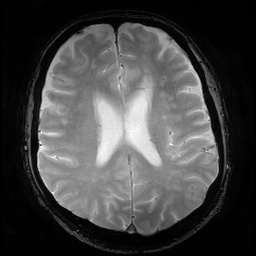

In [ ]:
alex_1.get_sample_of_original_dataset(part="test")

Preprocessed Data Test Sample

Get sample of preprocessed dataset (test) with index: 0



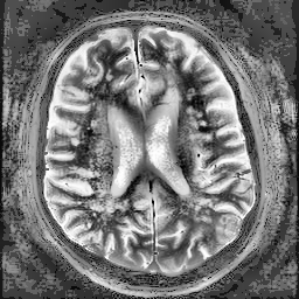

In [ ]:
alex_1.get_sample_of_preprocessed_dataset(part="test")

In [ ]:
# # Load pre-trained InceptionV3 model and set as feature extractor
# model = tv.models.inception_v3(weights=True)
# model.aux_logits = False
# model.fc = torch.nn.Identity()  # Replace fully connected layer with identity for feature extraction

# # Move model to GPU if available and use DataParallel
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print(f'Using {torch.cuda.device_count()} GPUs!')
#     model = torch.nn.DataParallel(model)
# model = model.to(device)

Extract Features

In [12]:
train_features, test_features = alex_1()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 97.2MB/s]


Save Features

In [15]:
alex_1.save_extractor("./drive/Shareddrives/huda/Ayang/base_cpu")

Destination path doesn't exists. Creating new dirs: ./drive/Shareddrives/huda/Ayang/base_cpu


In [ ]:
_ = AlzheptionExtractor.load_extractor("./drive/Shareddrives/huda/Ayang/base/AlzheptionExtractor.pkl")

In [ ]:
set(alex_1.train_labels)

{0, 1, 2, 3, 4, 5}

## Load Trained Model

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
alex_1 = AlzheptionExtractor.load_extractor("./drive/Shareddrives/huda/Ayang/base/AlzheptionExtractor.pkl")

## Classification

In [54]:
# Hyperparameters:
batch_size = 128
num_neurons = 1024
prefetch_size = 2048
n_splits = 10
n_repeats = 1

In [ ]:
# Initialize OSELMLayer with specified parameters
layer = OSELMLayer(num_neurons, 'mish')

# Initialize OSELMModel with the OSELMLayer and other parameters
model = OSELMModel(layer, prefetch_size=prefetch_size, batch_size=batch_size, verbose=0)

# Perform cross-validation
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
scores = cross_val_score(model, alex_1.train_features, alex_1.train_labels, cv=cv, scoring='accuracy', error_score='raise')

# Print mean accuracy score
print(np.mean(scores))

0.4603583489380771


In [ ]:
alcl_1 = AlzheptionClassificator(
    extractor=alex_1,
    n_neurons=512, n_splits=10, n_repeats=10,
)

In [ ]:
# # Encode labels
# label_encoder = LabelEncoder()
# train_labels = label_encoder.fit_transform(train_labels)
# test_labels = label_encoder.transform(test_labels)

In [ ]:
# # Normalize extracted features
# train_features = preprocessing.normalize(train_features)
# test_features = preprocessing.normalize(test_features)

In [56]:
class OSKELMLayer(KELMLayer):
    def __init__(self, kernel, activation):
        super().__init__(kernel, activation)

    def fit(self, x, y, batch_size=128):
        # Cast inputs to float32
        x = tf.cast(x, dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        self.input = x

        num_batches = ceil(x.shape[0] / batch_size)

        K_sum = None
        y_sum = None

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, x.shape[0])
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]

            # Pad batch to ensure consistent dimensions
            if x_batch.shape[0] < batch_size:
                padding_size = batch_size - x_batch.shape[0]
                x_batch = tf.pad(x_batch, [[0, padding_size], [0, 0]], constant_values=0)
                y_batch = tf.pad(y_batch, [[0, padding_size], [0, 0]], constant_values=0)

            if self.nystrom_approximation:
                n_samples = int(self.random_pct * x_batch.shape[0])
                L = eval(f"{self.landmark_selection_method}_sampling(x_batch, n_samples)")
                C = calculate_pairwise_distances_vector(x_batch, L, self.kernel.ev)
                W = calculate_pairwise_distances(L, self.kernel.ev)
                diagonal = tf.linalg.diag_part(W)
                W = tf.linalg.set_diag(W, diagonal + 0.00001)
                K_batch = tf.matmul(tf.matmul(C, tf.linalg.inv(W)), C, transpose_b=True)
            else:
                K_batch = calculate_pairwise_distances(x_batch, self.kernel.ev)

            # Ensure K_batch is float32
            K_batch = tf.cast(K_batch, dtype=tf.float32)

            diagonal = tf.linalg.diag_part(K_batch)
            K_batch = tf.linalg.set_diag(K_batch, diagonal + 0.1)

            # Debug shapes
            # tf.print("K_batch shape:", tf.shape(K_batch))

            if K_sum is None:
                K_sum = tf.zeros_like(K_batch, dtype=tf.float32)
            if y_sum is None:
                y_sum = tf.zeros_like(y_batch, dtype=tf.float32)

            # Perform batch-wise accumulation
            K_sum = tf.add(K_sum, K_batch)
            y_sum = tf.add(y_sum, y_batch)

        self.K = tf.linalg.inv(K_sum)
        self.beta = tf.matmul(self.K, y_sum)

In [57]:
# Initialize KELM with a kernel function
# kernel = CombinedProductKernel([Kernel("rbf"), Kernel("laplacian")])
# kernel = CombinedSumKernel([Kernel("rbf"), Kernel("exponential")])
kernel = Kernel("rbf")
# kernel = Kernel("laplacian")
layer = OSKELMLayer(kernel, 'leaky_relu')
kelm_model = KELMModel(layer)

In [ ]:
pca = PCA(n_components=400)
pca_train_features = pca.fit_transform(alex_1.train_features)
pca_test_features = pca.transform(alex_1.test_features)

In [ ]:
pca_train_features.shape, alex_1.train_labels.__len__()

((3532, 400), 3532)

In [ ]:
# print(tf.convert_to_tensor(pca_train_features).device)
# print(tf.convert_to_tensor(alex_1.train_labels).device)

In [ ]:
# # Cross-validation for KELM
# cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
# scores = cross_val_score(kelm_model, alex_1.train_features, alex_1.train_labels, cv=cv, scoring='accuracy')
# print("Cross-validated accuracy:", np.mean(scores))

In [58]:
# Train KELM on the extracted training features
# with tf.device('/CPU:0'):
kelm_model.fit(alex_1.train_features, alex_1.train_labels)

In [59]:
# Evaluate the KELM model on the test set
# with tf.device('/CPU:0'):
predictions = []
for bs in range(0, alex_1.test_features.shape[0], batch_size):
    batch_features = alex_1.test_features[bs:bs + batch_size]
    batch_predictions = kelm_model.predict(batch_features)
    predictions.extend(batch_predictions)

predictions = np.array(predictions)

accuracy = accuracy_score(alex_1.test_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Matrix size-incompatible: In[0]: [128,3532], In[1]: [128,128] [Op:MatMul] name: 

In [ ]:
# # Save and load the trained model
# kelm_model.save("Saved Models/KELM_Inception_Model.h5")
# # loaded_model = kelm_model.load("Saved Models/KELM_Inception_Model.h5")

In [ ]:
raise

### ELM Classifier Training

In [ ]:
L = 2048 # Number of hidden neurons

print('Number of hidden neuros:', L)

elm = ELMClassifier(L=L, random_state=42) # ELM
elm.fit(alex_1.train_features, alex_1.train_labels) # Train

y_train_pred = elm.predict(alex_1.train_features) # Train predictions
y_test_pred = elm.predict(alex_1.test_features) # Test predictions

Number of hidden neuros: 2048


In [ ]:
accuracy_score(alex_1.train_labels, y_train_pred), accuracy_score(alex_1.test_labels, y_test_pred)

(0.9377123442808607, 0.3635334088335221)